In [1]:
%%capture
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
    %load_ext autoreload
    %autoreload 2

In [2]:
import logging
from pathlib import Path

import holoviews as hv
import hvplot.polars  # noqa
import polars as pl
import polars.selectors as cs
from polars import col

from src.data.database_manager import DatabaseManager
from src.features.scaling import scale_min_max
from src.log_config import configure_logging
from src.plots.correlations import (
    calculate_correlations_per_trial,
    calculate_participant_stats,
    plot_correlations_per_participant,
)

logger = logging.getLogger(__name__.rsplit(".", maxsplit=1)[-1])
configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado", "param", "numba"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)

In [3]:
db = DatabaseManager()
with db:
    df = db.get_trials("Explore_Data", exclude_problematic=True)

# Rename columns
df = df.rename(
    {
        "rating": "pain_rating",
        "pupil": "pupil_diameter",
    }
)

In [4]:
# Remove first 20 seconds
df = df.filter(col("normalized_timestamp") >= 20 * 1000)

In [5]:
scale_min_max(df).hvplot(
    x="timestamp",
    y=[
        "eda_raw",
        "eda_phasic",
        "eda_tonic",
        "pupil_diameter",
        "temperature",
    ],
    groupby=["trial_id"],
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'9d93d204-0a0e-409a-8002-014ea128337b': {'version…

# Temperature

In [6]:
referece = "temperature"
targets = [
    "pain_rating",
    "pupil_diameter",
    "eda_tonic",
    "eda_phasic",
    "heart_rate",
]
corr_by_trial = calculate_correlations_per_trial(df, referece, targets)

In [7]:
# Calculate mean correlation per participant
participant_means = calculate_participant_stats(corr_by_trial, targets)
participant_means.drop(cs.matches(".*_std$")).describe()

statistic,participant_id,pain_rating_mean,pupil_diameter_mean,eda_tonic_mean,eda_phasic_mean,heart_rate_mean
str,f64,f64,f64,f64,f64,f64
"""count""",42.0,42.0,42.0,42.0,42.0,42.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",21.5,0.769671,0.257875,0.209914,0.07438,0.12107
"""std""",12.267844,0.046978,0.208381,0.198379,0.062506,0.155774
"""min""",1.0,0.680072,-0.178848,-0.087408,-0.069094,-0.15245
"""25%""",11.0,0.736347,0.113513,0.053556,0.035646,-0.02015
"""50%""",22.0,0.783027,0.272663,0.148166,0.078458,0.114817
"""75%""",32.0,0.803761,0.446377,0.351614,0.119112,0.219456
"""max""",42.0,0.865567,0.613737,0.665896,0.191234,0.526137


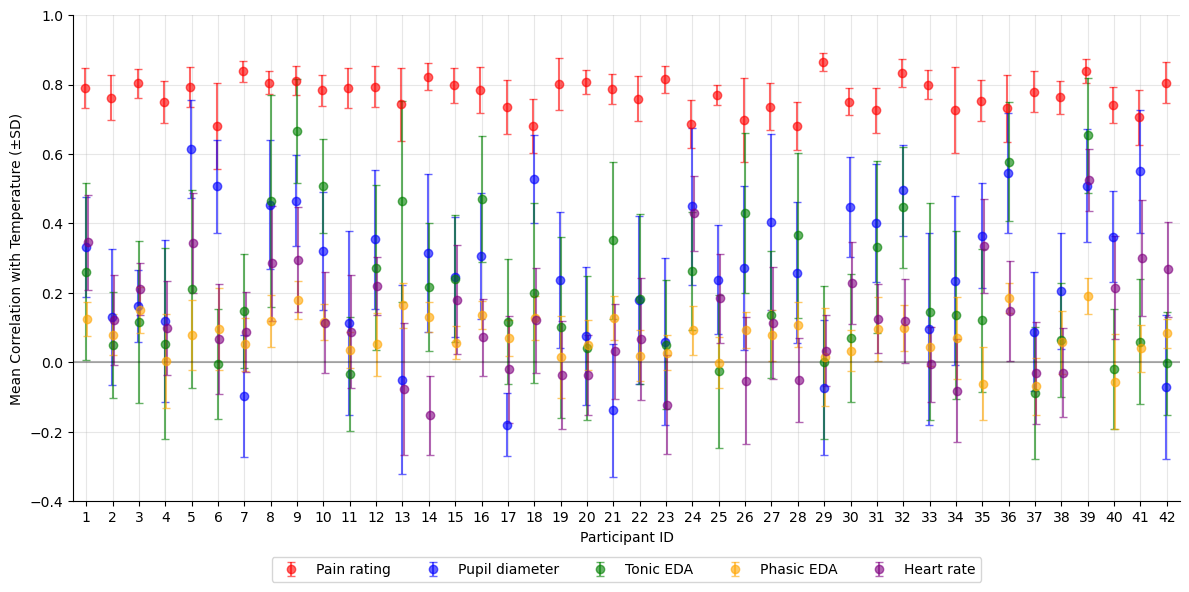

In [8]:
# Create the plot
labels_dict = {
    "pain_rating": "Pain rating",
    "pupil_diameter": "Pupil diameter",
    "eda_tonic": "Tonic EDA",
    "eda_phasic": "Phasic EDA",
    "heart_rate": "Heart rate",
}
fig = plot_correlations_per_participant(participant_means, targets, labels_dict)

In [31]:
# Save figure
import os
from pathlib import Path

from dotenv import load_dotenv

load_dotenv()
FIGURE_DIR = Path(os.getenv("FIGURE_DIR"))


# Save the figure
path = FIGURE_DIR / "correlations_with_temperature.png"
fig.savefig(path)